In [57]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

database = pd.read_csv('en.Twitter_May_June_2022_5000_chinese.csv')
database.text=database.text.astype(str)

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
database

,Datetime,Tweet Id,text,usernames,Stomach,Place
0,2022-05-31 23:38:42 + 00:00,1531782249464537088,Shanghai announced a complete restart of the c...,Wufanus,NaN,NaN
1,2022-05-31 23:10:59 + 00:00,1531775274085490690,"On May 29, Shanghai held a press conference on...",Jessie2021626,NaN,NaN
2,2022-05-31 22:39:12 + 00:00,1531767276453568512,@peterliu2121 @8DTzwKSsKMmEwNV @firelemond @Re...,gwrcc6guukw7iyc,NaN,NaN
3,2022-05-31 21:43:20 + 00:00,1531753217633071104,Is the Shanghai epidemic really over? \r\n\r\n...,ez2p8,NaN,NaN
4,2022-05-31 21:38:33 + 00:00,1531752016183103488,The Shanghai government “The Shanghai governme...,ecpp7jhczja8ct3,NaN,NaN
...,...,...,...,...,...,...
4997,2022-04-08 23:29:49 + 00:00,1512573457820696578,@Jam79922967 The main thing in Shanghai is tha...,lingxia 273d,NaN,NaN
4998,2022-04-08 23:23:57 + 00:00,1512571984127066116,Taobao bought things for my girlfriend and bou...,MKD007,NaN,NaN
4999,2022-04-08 23:10:26 + 00:00,1512568579547447301,The closure of Shanghai has at least one revel...,Tansunit,NaN,NaN
5000,2022-04-08 22:58:28 + 00:00,1512565567613374467,"@198920042014 The epidemic has closed down, th...",k3fldpg4qf0obtg,NaN,NaN


In [59]:
#preprocess

In [60]:
preprocess_review = pd.DataFrame(database['text'])

In [61]:
preprocess_review

,text
0,Shanghai announced a complete restart of the c...
1,"On May 29, Shanghai held a press conference on..."
2,@peterliu2121 @8DTzwKSsKMmEwNV @firelemond @Re...
3,Is the Shanghai epidemic really over? \r\n\r\n...
4,The Shanghai government “The Shanghai governme...
...,...
4997,@Jam79922967 The main thing in Shanghai is tha...
4998,Taobao bought things for my girlfriend and bou...
4999,The closure of Shanghai has at least one revel...
5000,"@198920042014 The epidemic has closed down, th..."


In [62]:
# lower
overall_reviews_lower = []

for i in preprocess_review['text']:
    overall_reviews_lower.append(i.lower())

preprocess_review['text'] = overall_reviews_lower

In [63]:
preprocess_review

,text
0,shanghai announced a complete restart of the c...
1,"on may 29, shanghai held a press conference on..."
2,@peterliu2121 @8dtzwksskmmewnv @firelemond @re...
3,is the shanghai epidemic really over? \r\n\r\n...
4,the shanghai government “the shanghai governme...
...,...
4997,@jam79922967 the main thing in shanghai is tha...
4998,taobao bought things for my girlfriend and bou...
4999,the closure of shanghai has at least one revel...
5000,"@198920042014 the epidemic has closed down, th..."


In [64]:
# remove punctuations

punctuations = '''()[]{};:'"\,<>./?@#$%^&*_~-'''

def remove_punct(text):
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct += char
        else:
            no_punct += " "
    
    return re.sub(' +', ' ',no_punct)

overall_reviews_remove_punct = []


for i in overall_reviews_lower:
    overall_reviews_remove_punct.append(remove_punct(i))
    
preprocess_review['text_remove_punct'] = overall_reviews_remove_punct

In [65]:
preprocess_review

,text,text_remove_punct
0,shanghai announced a complete restart of the c...,shanghai announced a complete restart of the c...
1,"on may 29, shanghai held a press conference on...",on may 29 shanghai held a press conference on ...
2,@peterliu2121 @8dtzwksskmmewnv @firelemond @re...,peterliu2121 8dtzwksskmmewnv firelemond realc...
3,is the shanghai epidemic really over? \r\n\r\n...,is the shanghai epidemic really over \r\n\r\np...
4,the shanghai government “the shanghai governme...,the shanghai government “the shanghai governme...
...,...,...
4997,@jam79922967 the main thing in shanghai is tha...,jam79922967 the main thing in shanghai is tha...
4998,taobao bought things for my girlfriend and bou...,taobao bought things for my girlfriend and bou...
4999,the closure of shanghai has at least one revel...,the closure of shanghai has at least one revel...
5000,"@198920042014 the epidemic has closed down, th...",198920042014 the epidemic has closed down the...


In [66]:
# remove stopwords
import gensim

all_stopwords = gensim.parsing.preprocessing.STOPWORDS

additional_stop_words = ['']

all_stopwords = all_stopwords.union(set(additional_stop_words))

def remove_mystopwords(sentence):
    tokens = sentence.split(" ")
    tokens_filtered= [word for word in tokens if not word in all_stopwords]
    clean = (" ").join(tokens_filtered)
    return clean

overall_reviews_clean = []

for i in overall_reviews_remove_punct:
    overall_reviews_clean.append(remove_mystopwords(i))

preprocess_review['text_clean'] = overall_reviews_clean

In [67]:
preprocess_review

,text,text_remove_punct,text_clean
0,shanghai announced a complete restart of the c...,shanghai announced a complete restart of the c...,shanghai announced complete restart city febru...
1,"on may 29, shanghai held a press conference on...",on may 29 shanghai held a press conference on ...,29 shanghai held press conference prevention c...
2,@peterliu2121 @8dtzwksskmmewnv @firelemond @re...,peterliu2121 8dtzwksskmmewnv firelemond realc...,peterliu2121 8dtzwksskmmewnv firelemond realco...
3,is the shanghai epidemic really over? \r\n\r\n...,is the shanghai epidemic really over \r\n\r\np...,shanghai epidemic \r\n\r\npangu news closed cc...
4,the shanghai government “the shanghai governme...,the shanghai government “the shanghai governme...,shanghai government “the shanghai government a...
...,...,...,...
4997,@jam79922967 the main thing in shanghai is tha...,jam79922967 the main thing in shanghai is tha...,jam79922967 main thing shanghai digital publis...
4998,taobao bought things for my girlfriend and bou...,taobao bought things for my girlfriend and bou...,taobao bought things girlfriend bought shenzhe...
4999,the closure of shanghai has at least one revel...,the closure of shanghai has at least one revel...,closure shanghai revelation people living citi...
5000,"@198920042014 the epidemic has closed down, th...",198920042014 the epidemic has closed down the...,198920042014 epidemic closed party suspended t...


In [68]:
#lemmatize 

def lemmatizing(string):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(string)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

overall_reviews_lemme = []

for i in overall_reviews_clean:
    overall_reviews_lemme.append(lemmatizing(i))

preprocess_review['text_lemme'] = overall_reviews_lemme

In [69]:
preprocess_review

,text,text_remove_punct,text_clean,text_lemme
0,shanghai announced a complete restart of the c...,shanghai announced a complete restart of the c...,shanghai announced complete restart city febru...,shanghai announced complete restart city febru...
1,"on may 29, shanghai held a press conference on...",on may 29 shanghai held a press conference on ...,29 shanghai held press conference prevention c...,29 shanghai held press conference prevention c...
2,@peterliu2121 @8dtzwksskmmewnv @firelemond @re...,peterliu2121 8dtzwksskmmewnv firelemond realc...,peterliu2121 8dtzwksskmmewnv firelemond realco...,peterliu2121 8dtzwksskmmewnv firelemond realco...
3,is the shanghai epidemic really over? \r\n\r\n...,is the shanghai epidemic really over \r\n\r\np...,shanghai epidemic \r\n\r\npangu news closed cc...,shanghai epidemic pangu news closed ccp s chin...
4,the shanghai government “the shanghai governme...,the shanghai government “the shanghai governme...,shanghai government “the shanghai government a...,shanghai government “ the shanghai government ...
...,...,...,...,...
4997,@jam79922967 the main thing in shanghai is tha...,jam79922967 the main thing in shanghai is tha...,jam79922967 main thing shanghai digital publis...,jam79922967 main thing shanghai digital publis...
4998,taobao bought things for my girlfriend and bou...,taobao bought things for my girlfriend and bou...,taobao bought things girlfriend bought shenzhe...,taobao bought thing girlfriend bought shenzhen...
4999,the closure of shanghai has at least one revel...,the closure of shanghai has at least one revel...,closure shanghai revelation people living citi...,closure shanghai revelation people living city...
5000,"@198920042014 the epidemic has closed down, th...",198920042014 the epidemic has closed down the...,198920042014 epidemic closed party suspended t...,198920042014 epidemic closed party suspended t...


In [70]:
preprocess_review.to_csv('new_Cleaned_preprocessing_en.Twitter_May_June_2022_5000_chinese.csv', index=False)

In [84]:
#Sentiment Analysis
# References: 1)https://www.youtube.com/watch?v=b9-0GpCqAQw&t=5s 2)https://huggingface.co/arpanghoshal/EmoRoBERTa

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

database1 = pd.read_csv('en.Twitter_May_June_2022_5000_chinese.csv')

In [99]:
database2 = database1
database2 = database2.applymap(str)

In [100]:
#Size of dataset
database2.shape

(5002, 7)

In [101]:
# New sentiment (Emoroberta - dataset labelled 58000 reddit comments with 28 emotions)
# Reference - https://github.com/amrrs/emotion-detection-from-text-python/blob/main/Text_Emotion_Detection_in_Python.ipynb

In [102]:
#Install pytorch
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
!pip install transformers -q


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [104]:
!pip install tensorflow


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
#from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline
from transformers import pipeline

In [106]:
#pipeline route (speed)
#emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa' , return_all_scores= True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
C:\Users\Chung KY\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [107]:
#Append top 3 emotions into dataframe
database2['top_emotion'] = database2['text_lemme'][0:2500].apply(emotion,top_k=3)
database2

,Datetime,Tweet Id,text,usernames,Stomach,Place,text_lemme,top_emotion
0,2022-05-31 23:38:42 + 00:00,1.53178E+18,Shanghai announced a complete restart of the c...,Wufanus,nan,nan,shanghai announced complete restart city febru...,"[{'label': 'neutral', 'score': 0.9926306009292..."
1,2022-05-31 23:10:59 + 00:00,1.53178E+18,"On May 29, Shanghai held a press conference on...",Jessie2021626,nan,nan,29 shanghai held press conference prevention c...,"[{'label': 'neutral', 'score': 0.6338756084442..."
2,2022-05-31 22:39:12 + 00:00,1.53177E+18,@peterliu2121 @8DTzwKSsKMmEwNV @firelemond @Re...,gwrcc6guukw7iyc,nan,nan,peterliu2121 8dtzwksskmmewnv firelemond realco...,"[{'label': 'neutral', 'score': 0.9974021911621..."
3,2022-05-31 21:43:20 + 00:00,1.53175E+18,Is the Shanghai epidemic really over? \r\n\r\n...,ez2p8,nan,nan,shanghai epidemic pangu news closed ccp s chin...,"[{'label': 'neutral', 'score': 0.9931761622428..."
4,2022-05-31 21:38:33 + 00:00,1.53175E+18,The Shanghai government “The Shanghai governme...,ecpp7jhczja8ct3,nan,nan,shanghai government “ the shanghai government ...,"[{'label': 'amusement', 'score': 0.86504197120..."
...,...,...,...,...,...,...,...,...
4997,2022-04-08 23:29:49 + 00:00,1.51257E+18,@Jam79922967 The main thing in Shanghai is tha...,lingxia 273d,nan,nan,jam79922967 main thing shanghai digital publis...,NaN
4998,2022-04-08 23:23:57 + 00:00,1.51257E+18,Taobao bought things for my girlfriend and bou...,MKD007,nan,nan,taobao bought thing girlfriend bought shenzhen...,NaN
4999,2022-04-08 23:10:26 + 00:00,1.51257E+18,The closure of Shanghai has at least one revel...,Tansunit,nan,nan,closure shanghai revelation people living city...,NaN
5000,2022-04-08 22:58:28 + 00:00,1.51257E+18,"@198920042014 The epidemic has closed down, th...",k3fldpg4qf0obtg,nan,nan,198920042014 epidemic closed party suspended t...,NaN


In [108]:
#Extracting data frame into csv for data visualization
database2.to_csv('top3_emotions_en.Twitter_May_June_2022_5000_chinese_chinese_1.csv', index=False)

# Visualization

In [47]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('Twitter_Covid-19_Lockdown_5000.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


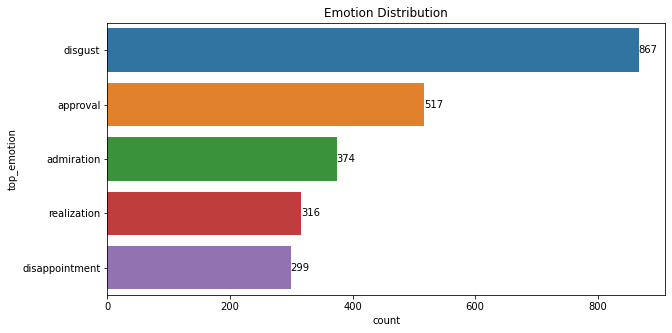

In [48]:
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/Twitter_Covid-19_Lockdown_5000_Top_5_emotions.png', dpi=400, bbox_inches="tight")

In [49]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('Twitter_Jan_Mar_5000.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


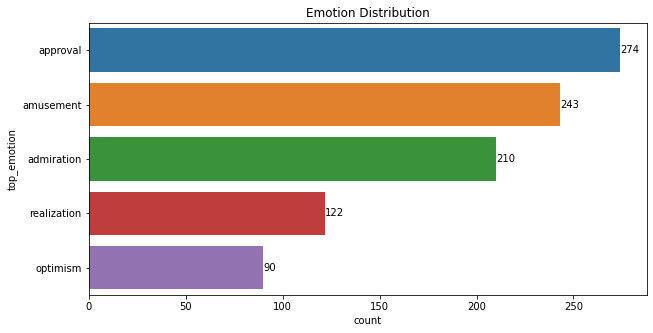

In [50]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/Twitter_Jan_Mar_5000_Top_5_emotions.png', dpi=400, bbox_inches="tight")

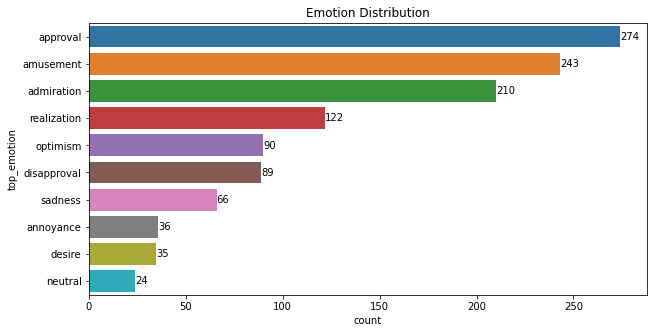

In [51]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:10].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/Twitter_Jan_Mar_5000_Top_10_emotions.png', dpi=400, bbox_inches="tight")

In [52]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('Twitter_Mar_5000.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


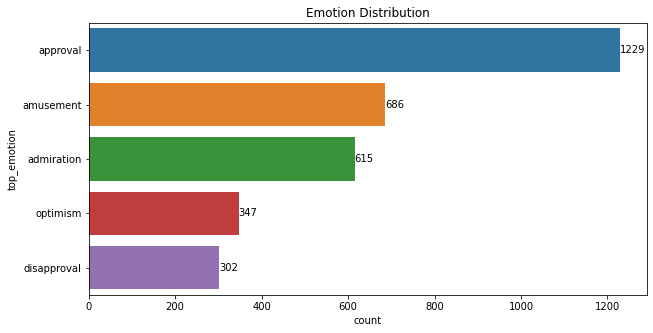

In [53]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/Twitter_Mar_5000_Top_5_emotions.png', dpi=400, bbox_inches="tight")

In [54]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('Twitter_May_Nov_5000.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


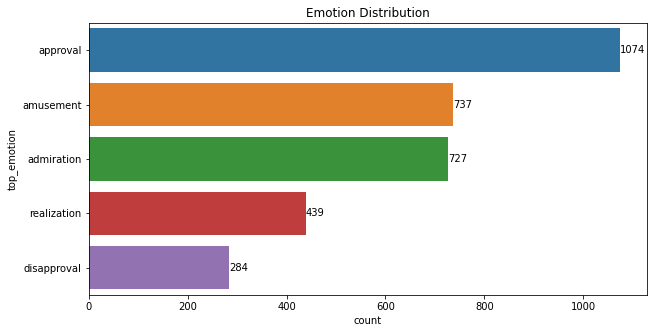

In [55]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/Twitter_May_Nov_5000_Top_5_emotions.png', dpi=400, bbox_inches="tight")

In [56]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('en.Twitter_Covid-19_Lockdown_5000_chinese.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


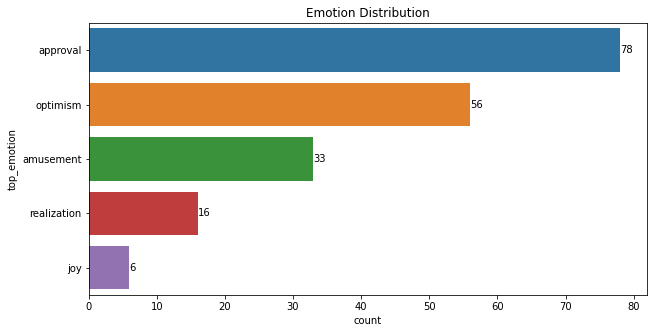

In [57]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/en.Twitter_Covid-19_Lockdown_5000_chinese_Top_5_emotions.png', dpi=400, bbox_inches="tight")

In [58]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('en.Twitter_Jan_Apr_2020_5000_chinese.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


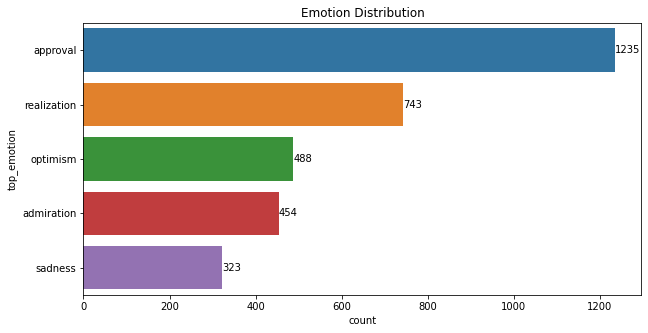

In [59]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/en.Twitter_Jan_Apr_2020_5000_chinese_Top_5_emotions.png', dpi=400, bbox_inches="tight")

In [60]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib
import seaborn as sns
%matplotlib inline

database = pd.read_csv('en.Twitter_May_June_2022_5000_chinese.csv')

[nltk_data] Downloading package stopwords to C:\Users\Chung
[nltk_data]     KY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


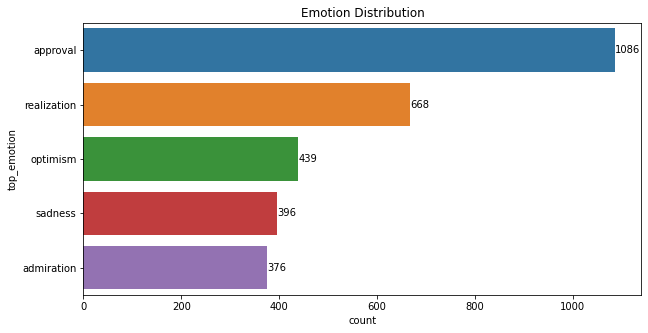

In [61]:
#Display bar chart
plt.figure(figsize=(10,5))
ax = sns.countplot(data=database, y = 'top_emotion', order=database['top_emotion'].value_counts().iloc[:5].index)
for label in ax.containers:
    ax.bar_label(label)
plt.title('Emotion Distribution')

plt.savefig('../Twitter_Output/en.Twitter_May_June_2022_5000_Top_5_emotions.png', dpi=400, bbox_inches="tight")